In [1]:
import numpy as np
import pandas as pd
pd.set_option("display.max_columns", None)
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme()
import os
from itertools import cycle

from sklearn.svm import SVC
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import accuracy_score, roc_auc_score, classification_report, RocCurveDisplay, confusion_matrix, ConfusionMatrixDisplay
from sklearn.preprocessing import RobustScaler, LabelEncoder
from tensorflow.keras.utils import to_categorical

import optuna

c:\Users\shoha\AppData\Local\Programs\Python\Python312\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
pwd = os.getcwd()
pwd

'd:\\Research Projects\\HEA\\Featurize_New_Alloys\\HEA'

In [3]:
df = pd.read_csv(pwd+"/raw_dataset/HEA_tr_NETCORE.csv")
print("Shape of Dataframe: ", df.shape)
df.head()

Shape of Dataframe:  (1167, 44)


,Alloy,avg_dev_AtomicWeight,maximum_MeltingT,avg_dev_MeltingT,mode_MeltingT,avg_dev_Column,mean_Row,mode_Row,minimum_CovalentRadius,maximum_CovalentRadius,range_CovalentRadius,avg_dev_CovalentRadius,mode_CovalentRadius,maximum_Electronegativity,mean_Electronegativity,mode_Electronegativity,mean_NsValence,maximum_NpValence,mean_NpValence,avg_dev_NpValence,range_NdValence,mean_NdValence,avg_dev_NdValence,avg_dev_NValence,mode_NValence,maximum_NdUnfilled,range_NdUnfilled,avg_dev_NdUnfilled,mode_NUnfilled,minimum_GSvolume_pa,range_GSvolume_pa,mode_GSvolume_pa,maximum_GSbandgap,avg_dev_GSbandgap,range_GSmagmom,minimum_SpaceGroupNumber,maximum_SpaceGroupNumber,mean_SpaceGroupNumber,range_Column,maximum_NpUnfilled,maximum_NdValence,mode_MendeleevNumber,range_NUnfilled,Phase
0,Al0.5NbTaTiV,3.838070,3290.0,584.546173,7.571474,0.966843,4.555556,4,121,170,3.912023,2.391138,153,1.63,1.572222,0.916291,1.777778,0.693147,0.111111,0.180262,4,2.666667,0.635989,1.797913,1.609438,8,8,0.908856,7,2.639771,1.819699,2.639771,0.0,0.0,0.000023,194,229,220.777778,9,5,4,43,3,BCC
1,Al0.75MoNbTiV,3.255577,2896.0,521.067701,7.571474,1.140210,4.263158,4,121,164,3.784190,2.377029,153,2.16,1.713158,0.932164,1.578947,0.693147,0.157895,0.235805,5,2.947368,0.845714,0.598806,1.609438,8,8,1.074312,6,2.639771,1.819699,2.639771,0.0,0.0,0.000023,194,229,221.000000,9,5,5,43,3,BCC
2,Al0.25MoNbTiV,3.205911,2896.0,441.662561,7.571474,0.758442,4.411765,4,121,164,3.784190,1.950841,153,2.16,1.725294,0.932164,1.529412,0.693147,0.058824,0.105014,5,3.294118,0.758442,0.492669,1.609438,8,8,0.833360,6,2.639771,1.819699,2.639771,0.0,0.0,0.000023,194,229,220.529412,9,5,5,43,3,BCC
3,Al0.25NbTaTiV,3.825406,3290.0,539.821730,7.571474,0.648931,4.647059,4,121,170,3.912023,2.140270,153,1.63,1.570000,0.916291,1.764706,0.693147,0.058824,0.105014,4,2.823529,0.542163,1.825219,1.609438,8,8,0.718768,7,2.639771,1.819699,2.639771,0.0,0.0,0.000023,194,229,220.529412,9,5,4,43,3,BCC
4,Al0.2MoTaTiV,3.838178,3290.0,565.511565,7.571474,0.703300,4.666667,4,121,170,3.912023,2.105461,153,2.16,1.702857,0.916291,1.761905,0.693147,0.047619,0.086822,5,3.095238,0.645547,1.812332,1.609438,8,8,0.829650,6,2.639771,1.809927,2.639771,0.0,0.0,0.000023,194,229,220.476191,9,5,5,43,3,BCC


In [4]:
# SHUFFLE THE DATASET
df = df.sample(frac=1, random_state=42)
X = df.copy().drop(columns=["Alloy", "Phase"])
y = df["Phase"].astype("category")
print(f"Shape of feature: {X.shape}\nShape of labels: {y.shape}")

Shape of feature: (1167, 42)
Shape of labels: (1167,)


In [5]:
# check class imbalance
print(y.value_counts(ascending=False))

Phase
MIP        428
BCC        363
FCC        211
FCC_BCC    165
Name: count, dtype: int64


In [6]:
from imblearn.over_sampling import SMOTE
X, y = SMOTE(random_state=42).fit_resample(X, y)
print(f"Shape of feature: {X.shape}\nShape of labels: {y.shape}")

Shape of feature: (1712, 42)
Shape of labels: (1712,)


c:\Users\shoha\AppData\Local\Programs\Python\Python312\Lib\site-packages\joblib\externals\loky\backend\context.py:136: UserWarning: Could not find the number of physical cores for the following reason:
found 0 physical cores < 1
Returning the number of logical cores instead. You can silence this warning by setting LOKY_MAX_CPU_COUNT to the number of cores you want to use.
  warnings.warn(
  File "c:\Users\shoha\AppData\Local\Programs\Python\Python312\Lib\site-packages\joblib\externals\loky\backend\context.py", line 282, in _count_physical_cores
    raise ValueError(f"found {cpu_count_physical} physical cores < 1")


In [7]:
# check for class imbalance
print(y.value_counts(ascending=False))

Phase
BCC        428
FCC        428
FCC_BCC    428
MIP        428
Name: count, dtype: int64


In [8]:
# SCALE FEATURES
X = pd.DataFrame(RobustScaler().fit_transform(X), columns=X.columns)
X.head()

,avg_dev_AtomicWeight,maximum_MeltingT,avg_dev_MeltingT,mode_MeltingT,avg_dev_Column,mean_Row,mode_Row,minimum_CovalentRadius,maximum_CovalentRadius,range_CovalentRadius,avg_dev_CovalentRadius,mode_CovalentRadius,maximum_Electronegativity,mean_Electronegativity,mode_Electronegativity,mean_NsValence,maximum_NpValence,mean_NpValence,avg_dev_NpValence,range_NdValence,mean_NdValence,avg_dev_NdValence,avg_dev_NValence,mode_NValence,maximum_NdUnfilled,range_NdUnfilled,avg_dev_NdUnfilled,mode_NUnfilled,minimum_GSvolume_pa,range_GSvolume_pa,mode_GSvolume_pa,maximum_GSbandgap,avg_dev_GSbandgap,range_GSmagmom,minimum_SpaceGroupNumber,maximum_SpaceGroupNumber,mean_SpaceGroupNumber,range_Column,maximum_NpUnfilled,maximum_NdValence,mode_MendeleevNumber,range_NUnfilled
0,0.161097,1.256140,0.606754,0.532601,0.521256,-0.216360,0.0,0.0,0.18,0.584759,0.717467,1.363636,0.25,0.232362,0.449317,-1.196825,0.000000,0.477222,0.422557,0.000000,-0.304043,0.175303,-0.008391,0.000000,0.000000,0.0,0.190333,1.333333,0.000000,0.000000,0.336801,0.000,0.000000,0.0,0.0,0.0,0.640823,0.000000,0.0,0.0,0.000000,0.0
1,-0.709468,-0.647368,-0.538152,-0.471801,-0.863198,0.220453,0.0,1.0,-0.42,-0.427776,-1.279471,0.000000,0.05,1.471545,1.916202,-0.110975,0.584963,-0.223215,-0.254527,-0.666667,1.487024,-0.236945,-0.963679,0.560099,-0.333333,-0.5,-0.196263,-0.333333,0.000000,10.948033,-0.030237,0.000,0.000000,0.0,-53.0,0.0,-0.640578,-0.333333,-0.2,1.0,0.666667,-1.0
2,-0.551801,-0.647368,-0.934202,0.039657,-0.977210,-0.216360,0.0,0.0,-0.70,-0.814217,-1.599888,0.000000,0.00,1.090976,1.916202,1.809577,0.000000,0.026149,0.020301,0.000000,0.584874,-0.225051,-0.802636,0.560099,-0.333333,-0.5,-0.853525,0.000000,0.000000,0.000000,-0.030237,0.000,0.000000,0.0,0.0,0.0,-0.694305,-0.666667,0.0,0.0,0.666667,-1.0
3,0.428073,2.882456,0.969928,-1.266392,0.594814,-1.406341,-1.0,-15.0,-0.42,1.434420,1.058207,-0.272727,0.64,0.850365,0.000000,0.362050,0.584963,1.529725,1.115875,0.000000,-0.534503,0.775456,0.299071,-1.247204,0.000000,0.0,0.262099,0.000000,-79.249736,4.490789,-0.030237,4.496,0.616735,0.0,0.0,0.0,-0.283342,0.333333,0.0,0.0,0.000000,0.0
4,0.071655,1.256140,0.363886,0.039657,0.103571,0.140634,0.0,0.0,0.18,0.584759,0.646848,0.000000,0.25,0.820978,0.449317,-0.535416,0.000000,0.161471,0.153797,0.000000,0.067211,0.047385,-0.120768,0.000000,0.000000,0.0,-0.141745,0.000000,0.000000,0.000000,-0.030237,0.000,0.000000,0.0,0.0,0.0,0.269152,0.000000,0.0,0.0,0.000000,0.0


In [9]:
# Label encode y and then to_categorical
lb_enc = LabelEncoder()
y = lb_enc.fit_transform(y)

In [10]:
labels = list(lb_enc.classes_)
labels

['BCC', 'FCC', 'FCC_BCC', 'MIP']

In [11]:
print(dict(zip(lb_enc.inverse_transform([0, 1, 2, 3]), [0, 1, 2, 3])))

{'BCC': 0, 'FCC': 1, 'FCC_BCC': 2, 'MIP': 3}


In [12]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print(f"Shape of training features: {X_train.shape}")
print(f"Shape of training labels: {y_train.shape}")
print(f"Shape of test features: {X_test.shape}")
print(f"Shape of test labels: {y_test.shape}")

Shape of training features: (1369, 42)
Shape of training labels: (1369,)
Shape of test features: (343, 42)
Shape of test labels: (343,)


In [13]:
# DEFINE OBJECTIVE FUNCTION
def obj_fn(trial):
    # DEFINE PARAMETER SPACE
    params = {
        "C": trial.suggest_float("C", 0.1, 100, log=True),
        "kernel": trial.suggest_categorical("kernel",['linear', 'poly', 'rbf', 'sigmoid']),
        "degree": trial.suggest_int("degree", 2, 6),
        "gamma": trial.suggest_categorical("gamma", ["scale", "auto"]),
        "coef0": trial.suggest_float("coef0", -1, 1),
        "shrinking": trial.suggest_categorical("shrinking", [True, False]),
        "probability": trial.suggest_categorical("probability", [True])
    }
    # CONSTRUCT MODEL
    model = SVC(**params, random_state=42)
    model.fit(X_train, y_train)
    y_test_pred = model.predict(X_test)
    test_acc = accuracy_score(y_test, y_test_pred)

    return test_acc

In [14]:
# PERFORM BAYESIAN OPTIMIZATION
tpe = optuna.samplers.TPESampler()
study = optuna.create_study(direction="maximize", sampler=tpe)
study.optimize(obj_fn, n_trials=50, show_progress_bar=True)

[I 2024-10-04 04:00:22,634] A new study created in memory with name: no-name-84ec7b3e-7c87-402a-87d4-5290b815385e
Best trial: 0. Best value: 0.376093:   2%|▏         | 1/50 [00:00<00:18,  2.63it/s]

[I 2024-10-04 04:00:23,017] Trial 0 finished with value: 0.3760932944606414 and parameters: {'C': 0.14089723880714153, 'kernel': 'sigmoid', 'degree': 2, 'gamma': 'auto', 'coef0': 0.3497530619164875, 'shrinking': True, 'probability': True}. Best is trial 0 with value: 0.3760932944606414.


Best trial: 1. Best value: 0.740525:   4%|▍         | 2/50 [00:00<00:19,  2.49it/s]

[I 2024-10-04 04:00:23,429] Trial 1 finished with value: 0.7405247813411079 and parameters: {'C': 0.6237850526245569, 'kernel': 'rbf', 'degree': 4, 'gamma': 'auto', 'coef0': 0.1402421467279633, 'shrinking': True, 'probability': True}. Best is trial 1 with value: 0.7405247813411079.


Best trial: 1. Best value: 0.740525:   6%|▌         | 3/50 [00:01<00:17,  2.70it/s]

[I 2024-10-04 04:00:23,766] Trial 2 finished with value: 0.2099125364431487 and parameters: {'C': 0.42531038106976266, 'kernel': 'poly', 'degree': 2, 'gamma': 'scale', 'coef0': -0.5337634783977261, 'shrinking': True, 'probability': True}. Best is trial 1 with value: 0.7405247813411079.


Best trial: 1. Best value: 0.740525:   8%|▊         | 4/50 [00:01<00:18,  2.53it/s]

[I 2024-10-04 04:00:24,199] Trial 3 finished with value: 0.41690962099125367 and parameters: {'C': 0.122180879799316, 'kernel': 'sigmoid', 'degree': 6, 'gamma': 'scale', 'coef0': 0.45265913456748086, 'shrinking': True, 'probability': True}. Best is trial 1 with value: 0.7405247813411079.


Best trial: 4. Best value: 0.813411:  10%|█         | 5/50 [00:04<00:53,  1.18s/it]

[I 2024-10-04 04:00:26,782] Trial 4 finished with value: 0.8134110787172012 and parameters: {'C': 57.36291881543936, 'kernel': 'poly', 'degree': 5, 'gamma': 'auto', 'coef0': 0.182764293099565, 'shrinking': False, 'probability': True}. Best is trial 4 with value: 0.8134110787172012.


Best trial: 4. Best value: 0.813411:  12%|█▏        | 6/50 [00:04<00:44,  1.02s/it]

[I 2024-10-04 04:00:27,477] Trial 5 finished with value: 0.2915451895043732 and parameters: {'C': 0.20462892165987479, 'kernel': 'poly', 'degree': 6, 'gamma': 'auto', 'coef0': -0.9370765029040777, 'shrinking': False, 'probability': True}. Best is trial 4 with value: 0.8134110787172012.


Best trial: 6. Best value: 0.822157:  14%|█▍        | 7/50 [00:05<00:34,  1.26it/s]

[I 2024-10-04 04:00:27,805] Trial 6 finished with value: 0.8221574344023324 and parameters: {'C': 91.73621088608773, 'kernel': 'rbf', 'degree': 2, 'gamma': 'auto', 'coef0': 0.2968049088765088, 'shrinking': True, 'probability': True}. Best is trial 6 with value: 0.8221574344023324.


Best trial: 6. Best value: 0.822157:  16%|█▌        | 8/50 [00:05<00:31,  1.34it/s]

[I 2024-10-04 04:00:28,458] Trial 7 finished with value: 0.760932944606414 and parameters: {'C': 0.39282966160785115, 'kernel': 'linear', 'degree': 5, 'gamma': 'auto', 'coef0': 0.5631761389858978, 'shrinking': True, 'probability': True}. Best is trial 6 with value: 0.8221574344023324.


Best trial: 6. Best value: 0.822157:  18%|█▊        | 9/50 [00:06<00:25,  1.62it/s]

[I 2024-10-04 04:00:28,793] Trial 8 finished with value: 0.6997084548104956 and parameters: {'C': 6.57514106945072, 'kernel': 'rbf', 'degree': 4, 'gamma': 'scale', 'coef0': 0.9956425816591634, 'shrinking': False, 'probability': True}. Best is trial 6 with value: 0.8221574344023324.


Best trial: 6. Best value: 0.822157:  20%|██        | 10/50 [00:06<00:22,  1.77it/s]

[I 2024-10-04 04:00:29,227] Trial 9 finished with value: 0.41690962099125367 and parameters: {'C': 1.3334197662726899, 'kernel': 'poly', 'degree': 4, 'gamma': 'scale', 'coef0': -0.01914491934499085, 'shrinking': False, 'probability': True}. Best is trial 6 with value: 0.8221574344023324.


Best trial: 10. Best value: 0.825073:  22%|██▏       | 11/50 [00:06<00:19,  2.03it/s]

[I 2024-10-04 04:00:29,567] Trial 10 finished with value: 0.8250728862973761 and parameters: {'C': 89.08752537160605, 'kernel': 'rbf', 'degree': 3, 'gamma': 'auto', 'coef0': -0.28248085377632304, 'shrinking': True, 'probability': True}. Best is trial 10 with value: 0.8250728862973761.


Best trial: 10. Best value: 0.825073:  24%|██▍       | 12/50 [00:07<00:16,  2.24it/s]

[I 2024-10-04 04:00:29,890] Trial 11 finished with value: 0.8221574344023324 and parameters: {'C': 98.14589200608219, 'kernel': 'rbf', 'degree': 3, 'gamma': 'auto', 'coef0': -0.31707698228137904, 'shrinking': True, 'probability': True}. Best is trial 10 with value: 0.8250728862973761.


Best trial: 10. Best value: 0.825073:  26%|██▌       | 13/50 [00:07<00:15,  2.46it/s]

[I 2024-10-04 04:00:30,220] Trial 12 finished with value: 0.7988338192419825 and parameters: {'C': 21.38734894698756, 'kernel': 'rbf', 'degree': 3, 'gamma': 'auto', 'coef0': -0.15972075029925503, 'shrinking': True, 'probability': True}. Best is trial 10 with value: 0.8250728862973761.


Best trial: 10. Best value: 0.825073:  28%|██▊       | 14/50 [00:07<00:13,  2.62it/s]

[I 2024-10-04 04:00:30,543] Trial 13 finished with value: 0.7988338192419825 and parameters: {'C': 18.132852605857725, 'kernel': 'rbf', 'degree': 3, 'gamma': 'auto', 'coef0': -0.5799853525858878, 'shrinking': True, 'probability': True}. Best is trial 10 with value: 0.8250728862973761.


Best trial: 10. Best value: 0.825073:  30%|███       | 15/50 [00:38<05:36,  9.62s/it]

[I 2024-10-04 04:01:01,590] Trial 14 finished with value: 0.7463556851311953 and parameters: {'C': 34.72287267267307, 'kernel': 'linear', 'degree': 2, 'gamma': 'auto', 'coef0': 0.9489381662268948, 'shrinking': True, 'probability': True}. Best is trial 10 with value: 0.8250728862973761.


Best trial: 10. Best value: 0.825073:  32%|███▏      | 16/50 [00:39<03:52,  6.82s/it]

[I 2024-10-04 04:01:01,910] Trial 15 finished with value: 0.7988338192419825 and parameters: {'C': 7.653583871957486, 'kernel': 'rbf', 'degree': 3, 'gamma': 'auto', 'coef0': -0.9978235285414203, 'shrinking': True, 'probability': True}. Best is trial 10 with value: 0.8250728862973761.


Best trial: 10. Best value: 0.825073:  34%|███▍      | 17/50 [00:39<02:40,  4.87s/it]

[I 2024-10-04 04:01:02,244] Trial 16 finished with value: 0.8221574344023324 and parameters: {'C': 98.15801690518279, 'kernel': 'rbf', 'degree': 2, 'gamma': 'auto', 'coef0': 0.663069461625561, 'shrinking': True, 'probability': True}. Best is trial 10 with value: 0.8250728862973761.


Best trial: 10. Best value: 0.825073:  36%|███▌      | 18/50 [00:39<01:52,  3.52s/it]

[I 2024-10-04 04:01:02,591] Trial 17 finished with value: 0.7813411078717201 and parameters: {'C': 2.7449308996997037, 'kernel': 'rbf', 'degree': 3, 'gamma': 'auto', 'coef0': -0.34602034190563447, 'shrinking': True, 'probability': True}. Best is trial 10 with value: 0.8250728862973761.


Best trial: 10. Best value: 0.825073:  38%|███▊      | 19/50 [01:10<06:02, 11.69s/it]

[I 2024-10-04 04:01:33,335] Trial 18 finished with value: 0.7463556851311953 and parameters: {'C': 15.112810444898583, 'kernel': 'linear', 'degree': 2, 'gamma': 'scale', 'coef0': -0.6939430477483333, 'shrinking': False, 'probability': True}. Best is trial 10 with value: 0.8250728862973761.


Best trial: 10. Best value: 0.825073:  40%|████      | 20/50 [01:11<04:08,  8.28s/it]

[I 2024-10-04 04:01:33,655] Trial 19 finished with value: 0.3556851311953353 and parameters: {'C': 47.578629098395496, 'kernel': 'sigmoid', 'degree': 3, 'gamma': 'auto', 'coef0': -0.01784108762960701, 'shrinking': True, 'probability': True}. Best is trial 10 with value: 0.8250728862973761.


Best trial: 10. Best value: 0.825073:  42%|████▏     | 21/50 [01:11<02:50,  5.89s/it]

[I 2024-10-04 04:01:33,976] Trial 20 finished with value: 0.7988338192419825 and parameters: {'C': 7.8073041185951455, 'kernel': 'rbf', 'degree': 5, 'gamma': 'auto', 'coef0': 0.2374451837243976, 'shrinking': True, 'probability': True}. Best is trial 10 with value: 0.8250728862973761.


Best trial: 10. Best value: 0.825073:  44%|████▍     | 22/50 [01:11<01:58,  4.23s/it]

[I 2024-10-04 04:01:34,323] Trial 21 finished with value: 0.8192419825072886 and parameters: {'C': 75.42815311607977, 'kernel': 'rbf', 'degree': 3, 'gamma': 'auto', 'coef0': -0.25439013754722906, 'shrinking': True, 'probability': True}. Best is trial 10 with value: 0.8250728862973761.


Best trial: 10. Best value: 0.825073:  46%|████▌     | 23/50 [01:12<01:22,  3.05s/it]

[I 2024-10-04 04:01:34,642] Trial 22 finished with value: 0.8075801749271136 and parameters: {'C': 34.21475329029442, 'kernel': 'rbf', 'degree': 3, 'gamma': 'auto', 'coef0': -0.3948246559541796, 'shrinking': True, 'probability': True}. Best is trial 10 with value: 0.8250728862973761.


Best trial: 10. Best value: 0.825073:  48%|████▊     | 24/50 [01:12<00:58,  2.24s/it]

[I 2024-10-04 04:01:34,977] Trial 23 finished with value: 0.8192419825072886 and parameters: {'C': 69.2588840058061, 'kernel': 'rbf', 'degree': 2, 'gamma': 'auto', 'coef0': -0.1636027463859463, 'shrinking': True, 'probability': True}. Best is trial 10 with value: 0.8250728862973761.


Best trial: 10. Best value: 0.825073:  50%|█████     | 25/50 [01:12<00:41,  1.67s/it]

[I 2024-10-04 04:01:35,311] Trial 24 finished with value: 0.8046647230320699 and parameters: {'C': 30.68223038706293, 'kernel': 'rbf', 'degree': 4, 'gamma': 'auto', 'coef0': -0.7735281569799246, 'shrinking': True, 'probability': True}. Best is trial 10 with value: 0.8250728862973761.


Best trial: 10. Best value: 0.825073:  52%|█████▏    | 26/50 [01:13<00:30,  1.27s/it]

[I 2024-10-04 04:01:35,642] Trial 25 finished with value: 0.8221574344023324 and parameters: {'C': 95.77848733861502, 'kernel': 'rbf', 'degree': 3, 'gamma': 'auto', 'coef0': -0.4733660134522435, 'shrinking': True, 'probability': True}. Best is trial 10 with value: 0.8250728862973761.


Best trial: 10. Best value: 0.825073:  54%|█████▍    | 27/50 [01:13<00:22,  1.01it/s]

[I 2024-10-04 04:01:35,990] Trial 26 finished with value: 0.7142857142857143 and parameters: {'C': 11.519822672624763, 'kernel': 'rbf', 'degree': 2, 'gamma': 'scale', 'coef0': 0.016210526452886065, 'shrinking': False, 'probability': True}. Best is trial 10 with value: 0.8250728862973761.


Best trial: 10. Best value: 0.825073:  56%|█████▌    | 28/50 [01:13<00:17,  1.26it/s]

[I 2024-10-04 04:01:36,338] Trial 27 finished with value: 0.29737609329446063 and parameters: {'C': 3.6792443937354737, 'kernel': 'sigmoid', 'degree': 3, 'gamma': 'auto', 'coef0': 0.7200101947937154, 'shrinking': True, 'probability': True}. Best is trial 10 with value: 0.8250728862973761.


Best trial: 10. Best value: 0.825073:  58%|█████▊    | 29/50 [01:53<04:25, 12.63s/it]

[I 2024-10-04 04:02:16,580] Trial 28 finished with value: 0.749271137026239 and parameters: {'C': 46.557323133986515, 'kernel': 'linear', 'degree': 2, 'gamma': 'auto', 'coef0': -0.21474217481771746, 'shrinking': True, 'probability': True}. Best is trial 10 with value: 0.8250728862973761.


Best trial: 10. Best value: 0.825073:  60%|██████    | 30/50 [01:54<02:58,  8.94s/it]

[I 2024-10-04 04:02:16,894] Trial 29 finished with value: 0.33527696793002915 and parameters: {'C': 26.422319655997132, 'kernel': 'sigmoid', 'degree': 2, 'gamma': 'auto', 'coef0': 0.276315935976597, 'shrinking': True, 'probability': True}. Best is trial 10 with value: 0.8250728862973761.


Best trial: 10. Best value: 0.825073:  62%|██████▏   | 31/50 [01:54<02:00,  6.36s/it]

[I 2024-10-04 04:02:17,231] Trial 30 finished with value: 0.8134110787172012 and parameters: {'C': 52.39766108604342, 'kernel': 'rbf', 'degree': 4, 'gamma': 'auto', 'coef0': 0.4547894461989127, 'shrinking': True, 'probability': True}. Best is trial 10 with value: 0.8250728862973761.


Best trial: 10. Best value: 0.825073:  64%|██████▍   | 32/50 [01:54<01:21,  4.55s/it]

[I 2024-10-04 04:02:17,568] Trial 31 finished with value: 0.8221574344023324 and parameters: {'C': 93.6764323799243, 'kernel': 'rbf', 'degree': 2, 'gamma': 'auto', 'coef0': 0.7955809422211169, 'shrinking': True, 'probability': True}. Best is trial 10 with value: 0.8250728862973761.


Best trial: 10. Best value: 0.825073:  66%|██████▌   | 33/50 [01:55<00:55,  3.29s/it]

[I 2024-10-04 04:02:17,917] Trial 32 finished with value: 0.8221574344023324 and parameters: {'C': 98.94212721532523, 'kernel': 'rbf', 'degree': 2, 'gamma': 'auto', 'coef0': 0.6938765324912544, 'shrinking': True, 'probability': True}. Best is trial 10 with value: 0.8250728862973761.


Best trial: 10. Best value: 0.825073:  68%|██████▊   | 34/50 [01:55<00:38,  2.40s/it]

[I 2024-10-04 04:02:18,231] Trial 33 finished with value: 0.8134110787172012 and parameters: {'C': 43.85907023898908, 'kernel': 'rbf', 'degree': 2, 'gamma': 'auto', 'coef0': 0.09410199543081621, 'shrinking': True, 'probability': True}. Best is trial 10 with value: 0.8250728862973761.


Best trial: 10. Best value: 0.825073:  70%|███████   | 35/50 [01:55<00:26,  1.78s/it]

[I 2024-10-04 04:02:18,587] Trial 34 finished with value: 0.8192419825072886 and parameters: {'C': 65.46358413268952, 'kernel': 'rbf', 'degree': 3, 'gamma': 'auto', 'coef0': 0.48140459291624427, 'shrinking': True, 'probability': True}. Best is trial 10 with value: 0.8250728862973761.


Best trial: 10. Best value: 0.825073:  72%|███████▏  | 36/50 [01:56<00:18,  1.35s/it]

[I 2024-10-04 04:02:18,913] Trial 35 finished with value: 0.7871720116618076 and parameters: {'C': 97.3355358151275, 'kernel': 'rbf', 'degree': 2, 'gamma': 'scale', 'coef0': 0.5886734631548601, 'shrinking': True, 'probability': True}. Best is trial 10 with value: 0.8250728862973761.


Best trial: 10. Best value: 0.825073:  74%|███████▍  | 37/50 [01:57<00:15,  1.19s/it]

[I 2024-10-04 04:02:19,752] Trial 36 finished with value: 0.8075801749271136 and parameters: {'C': 25.10344673741575, 'kernel': 'poly', 'degree': 4, 'gamma': 'auto', 'coef0': 0.3502802106441374, 'shrinking': True, 'probability': True}. Best is trial 10 with value: 0.8250728862973761.


Best trial: 10. Best value: 0.825073:  76%|███████▌  | 38/50 [01:57<00:11,  1.06it/s]

[I 2024-10-04 04:02:20,100] Trial 37 finished with value: 0.8192419825072886 and parameters: {'C': 60.5140851033645, 'kernel': 'rbf', 'degree': 2, 'gamma': 'auto', 'coef0': -0.09890303283899843, 'shrinking': False, 'probability': True}. Best is trial 10 with value: 0.8250728862973761.


Best trial: 10. Best value: 0.825073:  78%|███████▊  | 39/50 [01:57<00:08,  1.32it/s]

[I 2024-10-04 04:02:20,432] Trial 38 finished with value: 0.5422740524781341 and parameters: {'C': 0.9090989384337055, 'kernel': 'sigmoid', 'degree': 3, 'gamma': 'scale', 'coef0': 0.31896351672837264, 'shrinking': True, 'probability': True}. Best is trial 10 with value: 0.8250728862973761.


Best trial: 10. Best value: 0.825073:  80%|████████  | 40/50 [01:58<00:08,  1.25it/s]

[I 2024-10-04 04:02:21,339] Trial 39 finished with value: 0.33527696793002915 and parameters: {'C': 42.173506908781455, 'kernel': 'poly', 'degree': 4, 'gamma': 'auto', 'coef0': -0.32986399164603286, 'shrinking': True, 'probability': True}. Best is trial 10 with value: 0.8250728862973761.


Best trial: 10. Best value: 0.825073:  82%|████████▏ | 41/50 [02:27<01:24,  9.35s/it]

[I 2024-10-04 04:02:50,623] Trial 40 finished with value: 0.7463556851311953 and parameters: {'C': 16.369936211868723, 'kernel': 'linear', 'degree': 5, 'gamma': 'auto', 'coef0': 0.14399564681099863, 'shrinking': False, 'probability': True}. Best is trial 10 with value: 0.8250728862973761.


Best trial: 10. Best value: 0.825073:  84%|████████▍ | 42/50 [02:28<00:53,  6.65s/it]

[I 2024-10-04 04:02:50,980] Trial 41 finished with value: 0.8192419825072886 and parameters: {'C': 76.5038268586462, 'kernel': 'rbf', 'degree': 3, 'gamma': 'auto', 'coef0': -0.5093295035079572, 'shrinking': True, 'probability': True}. Best is trial 10 with value: 0.8250728862973761.


Best trial: 10. Best value: 0.825073:  86%|████████▌ | 43/50 [02:28<00:33,  4.76s/it]

[I 2024-10-04 04:02:51,328] Trial 42 finished with value: 0.8221574344023324 and parameters: {'C': 96.71962358741453, 'kernel': 'rbf', 'degree': 3, 'gamma': 'auto', 'coef0': -0.5099902016425732, 'shrinking': True, 'probability': True}. Best is trial 10 with value: 0.8250728862973761.


Best trial: 10. Best value: 0.825073:  88%|████████▊ | 44/50 [02:29<00:20,  3.46s/it]

[I 2024-10-04 04:02:51,756] Trial 43 finished with value: 0.8192419825072886 and parameters: {'C': 62.59261479771726, 'kernel': 'rbf', 'degree': 3, 'gamma': 'auto', 'coef0': -0.43776820357327595, 'shrinking': True, 'probability': True}. Best is trial 10 with value: 0.8250728862973761.


Best trial: 10. Best value: 0.825073:  90%|█████████ | 45/50 [02:29<00:12,  2.59s/it]

[I 2024-10-04 04:02:52,310] Trial 44 finished with value: 0.6793002915451894 and parameters: {'C': 0.22371900416803545, 'kernel': 'rbf', 'degree': 6, 'gamma': 'auto', 'coef0': -0.6377472417872623, 'shrinking': True, 'probability': True}. Best is trial 10 with value: 0.8250728862973761.


Best trial: 10. Best value: 0.825073:  92%|█████████▏| 46/50 [02:30<00:07,  1.92s/it]

[I 2024-10-04 04:02:52,644] Trial 45 finished with value: 0.8075801749271136 and parameters: {'C': 35.64015790772936, 'kernel': 'rbf', 'degree': 2, 'gamma': 'auto', 'coef0': -0.825606582215314, 'shrinking': True, 'probability': True}. Best is trial 10 with value: 0.8250728862973761.


Best trial: 10. Best value: 0.825073:  94%|█████████▍| 47/50 [02:30<00:04,  1.40s/it]

[I 2024-10-04 04:02:52,859] Trial 46 finished with value: 0.5626822157434402 and parameters: {'C': 74.99350529663506, 'kernel': 'poly', 'degree': 3, 'gamma': 'scale', 'coef0': -0.2820150708556136, 'shrinking': True, 'probability': True}. Best is trial 10 with value: 0.8250728862973761.


Best trial: 10. Best value: 0.825073:  96%|█████████▌| 48/50 [02:30<00:02,  1.09s/it]

[I 2024-10-04 04:02:53,207] Trial 47 finished with value: 0.8163265306122449 and parameters: {'C': 57.52384708141062, 'kernel': 'rbf', 'degree': 4, 'gamma': 'auto', 'coef0': 0.8294836442387896, 'shrinking': False, 'probability': True}. Best is trial 10 with value: 0.8250728862973761.


Best trial: 10. Best value: 0.825073:  98%|█████████▊| 49/50 [02:30<00:00,  1.16it/s]

[I 2024-10-04 04:02:53,544] Trial 48 finished with value: 0.7988338192419825 and parameters: {'C': 20.627982126319804, 'kernel': 'rbf', 'degree': 4, 'gamma': 'auto', 'coef0': -0.44640230422774646, 'shrinking': True, 'probability': True}. Best is trial 10 with value: 0.8250728862973761.


Best trial: 10. Best value: 0.825073: 100%|██████████| 50/50 [02:31<00:00,  3.02s/it]

[I 2024-10-04 04:02:53,884] Trial 49 finished with value: 0.7988338192419825 and parameters: {'C': 11.869339167958747, 'kernel': 'rbf', 'degree': 2, 'gamma': 'auto', 'coef0': -0.10838265302864553, 'shrinking': True, 'probability': True}. Best is trial 10 with value: 0.8250728862973761.


In [15]:
best_model_params = study.best_params
best_model_params

{'C': 89.08752537160605,
 'kernel': 'rbf',
 'degree': 3,
 'gamma': 'auto',
 'coef0': -0.28248085377632304,
 'shrinking': True,
 'probability': True}

In [16]:
# BUILD MODEL USING BEST PARAMETERS AND EVALUATE
best_model = SVC(**best_model_params, random_state=42)
best_model.fit(X_train, y_train)
y_train_pred = best_model.predict(X_train)
y_test_pred = best_model.predict(X_test)

# CLASSIFICATION REPORT
print("Classification Report on Training Data")
print("-"*80)
print(classification_report(y_train, y_train_pred, target_names=labels, digits=4))

print("Classification Report on Test Data")
print("-"*80)
print(classification_report(y_test, y_test_pred, target_names=labels, digits=4))

# EVALUATE ROC-AUC SCORE
pred_proba = best_model.predict_proba(X_test)
roc_auc = roc_auc_score(y_test, pred_proba, multi_class='ovr')
print("-"*80)
print(f"ROC-AUC SCORE: {roc_auc*100: .4f} %")

Classification Report on Training Data
--------------------------------------------------------------------------------
              precision    recall  f1-score   support

         BCC     0.9000    0.9460    0.9224       352
         FCC     0.9556    0.8932    0.9233       337
     FCC_BCC     0.8676    0.9413    0.9030       341
         MIP     0.9650    0.8938    0.9280       339

    accuracy                         0.9189      1369
   macro avg     0.9220    0.9186    0.9192      1369
weighted avg     0.9217    0.9189    0.9192      1369

Classification Report on Test Data
--------------------------------------------------------------------------------
              precision    recall  f1-score   support

         BCC     0.8800    0.8684    0.8742        76
         FCC     0.8734    0.7582    0.8118        91
     FCC_BCC     0.8081    0.9195    0.8602        87
         MIP     0.7556    0.7640    0.7598        89

    accuracy                         0.8251       343
   

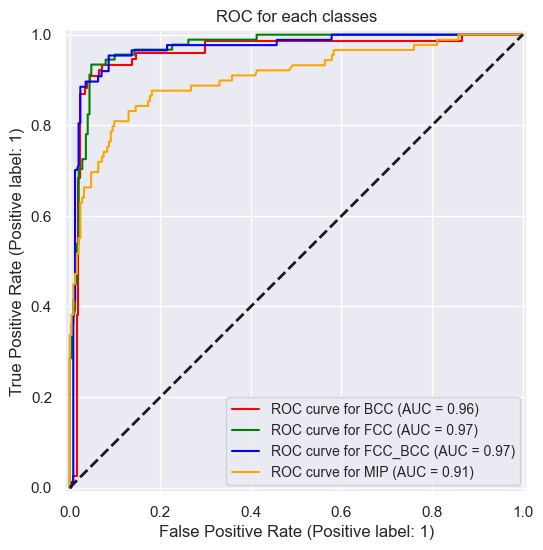

In [17]:
# PLOT ROC CURVE
fig, ax = plt.subplots(figsize=(6, 6))
y_test_oh = to_categorical(y_test)
colors = cycle(["red", "green", "blue", "orange"])
for class_id, color in zip(range(4), colors):
    RocCurveDisplay.from_predictions(
        y_test_oh[:, class_id],
        pred_proba[:, class_id],
        name=f"ROC curve for {labels[class_id]}",
        color=color,
        ax=ax,
    )
ax.plot([0, 1], [0, 1], 'k--', lw=2)
ax.legend(loc='lower right', fontsize='10')
plt.title("ROC for each classes")
plt.savefig(pwd+"/figures/svc_roc_curve.png", dpi=600, bbox_inches="tight")

Training accuracy per class: [0.94602273 0.89317507 0.94134897 0.89380531]
Testing accuracy per class: [0.86842105 0.75824176 0.91954023 0.76404494]


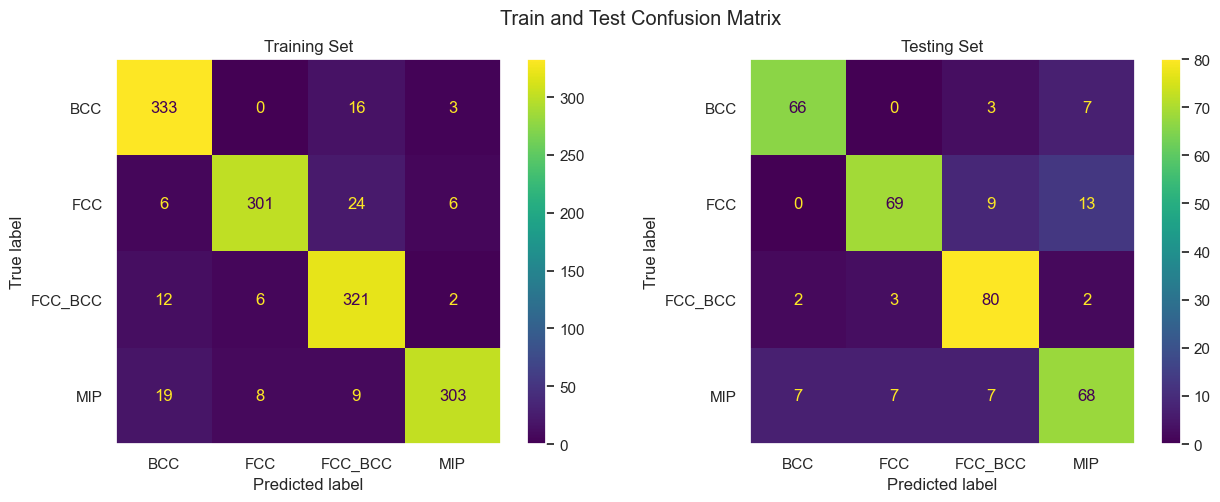

In [18]:
# CONFUSION MATRIX
cm_train = confusion_matrix(y_train, y_train_pred)
cm_test = confusion_matrix(y_test, y_test_pred)
f,(ax1, ax2) = plt.subplots(1,2, figsize = (15,5))
disp_train = ConfusionMatrixDisplay(confusion_matrix=cm_train, display_labels=labels)
disp_test = ConfusionMatrixDisplay(confusion_matrix=cm_test, display_labels=labels)
disp_train.plot(ax = ax1)
disp_test.plot(ax = ax2)
ax1.set_title('Training Set')
ax2.set_title('Testing Set')
ax1.grid(False)
ax2.grid(False)
plt.suptitle('Train and Test Confusion Matrix')
plt.savefig(pwd+"/figures/svc_cf.png", dpi=600, bbox_inches="tight")

# ACCURACY PER CLASS
acc_class_train = cm_train.diagonal() / cm_train.sum(axis=1)
acc_class_test = cm_test.diagonal() / cm_test.sum(axis=1)

print("Training accuracy per class:", acc_class_train)
print("Testing accuracy per class:", acc_class_test)

In [19]:
# 10 FOLD CROSS VALIDATION
kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
cv_scores = []

for train_idx, test_idx in kfold.split(X, y):
    X_train_cv, y_train_cv = X.iloc[train_idx], y[train_idx]
    X_test_cv, y_test_cv = X.iloc[test_idx], y[test_idx]
    best_model.fit(X_train_cv, y_train_cv)
    y_test_pred_cv = best_model.predict(X_test_cv)
    score = accuracy_score(y_test_cv, y_test_pred_cv)
    cv_scores.append(score*100)

print("Cross Validation Score")
print("-"*50)
print(f"Mean Accuracy: {np.mean(cv_scores): .4f} % \nStandard Deviation: (+/-){np.std(cv_scores): .4f} %")
print("-"*50)

Cross Validation Score
--------------------------------------------------
Mean Accuracy:  83.5234 % 
Standard Deviation: (+/-) 2.6958 %
--------------------------------------------------
